## Classification in `scikit-learn`

Goals:

* Practice with the `fit` and `predict` interface of sklearn models
* Compare and contrast regression and classification as machine learning tasks

## Setup

Much of this setup is the same as the regression notebook.

Let's import necessary modules: Pandas and NumPy for data wrangling, Matplotlib for plotting, and some sklearn models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, log_loss, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

We'll load the data. We're using a dataset of home sale prices from the Ames, Iowa assessor's database, described in [this paper](http://ww2.amstat.org/publications/jse/v19n3/decock.pdf).

In [2]:
ames = pd.read_csv('https://github.com/kcarnold/AmesHousing/blob/master/data/ames.csv.gz?raw=true', compression="gzip")
ames['price'] = ames["Sale_Price"] / 100_000 # Make `price` be in units of $100k, to be easier to interpret.
ames.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude,price
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035,2.150
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014,1.050
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659,1.720
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245,2.440
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899,1.899


We'll try to predict home price based on *location* (which the realtors assure us is the most important factor anyway). So we'll grab the Latitude and Longitude columns of the data. We'll call that input data `X`, by convention.

In [3]:
X = ames[['Longitude', 'Latitude']].values
X.shape

(2930, 2)

We'll do something different for `y`; see below.

## Task

Notice that the distribution of sale prices is skewed.

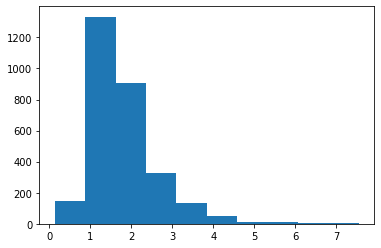

In [4]:
plt.hist(ames.price);

Skew can make regression hard because errors in the tails (in this case, the expensive houses) can dominate: mispredicting a million-dollar home by 1% is as bad as mispredicting a \$100k home by 10%!

One way to resolve this is to transform the target variable to be more evenly distributed. (For example, a log transformation will make all percentage errors equally important.) Another way is to transform it into a *classification* problem, where we predict whether the home price is *low*, *medium*, or *high*. We'll skip lots of nuance here and just split the prices into 3 equal buckets.

In [5]:
# This is some Pandas trickery. Enjoy, those who dare venture here! Otherwise don't worry about it.
ames['price_rank'] = ames.price.rank(pct=True)
ames['price_bin'] = 0 + (ames.price_rank > 1/3) + (ames.price_rank > 2/3)
ames.price_bin.value_counts()

0    981
1    980
2    969
Name: price_bin, dtype: int64

**Make a target `y` using the `price_bin` column of `ames`.**

In [7]:
y = ames['price_bin'].values
y.shape

(2930,)

**Split the data (`X` and `y`) into a training and validation set** using the same fraction and seed as the previous notebook.

In [10]:
# your code here
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)

We could use the plotting mechanism we used for regression in the previous notebook (try it, it does work), but it's a bit confusing because the model will be predicting 0, 1, or 2, while the data is in the original range. That would also omit one cool thing we gain by moving to a classifier: we get *probabilities*! You can interpret that as the model's *confidence* about a home price prediction. We could do this with regression too, but it's more complex; it comes for free with classification.

Here we define the new plotting function; don't worry about how it works.

In [9]:
def plot_class_probs(clf):
    lat_min = ames.Latitude.min()
    lat_max = ames.Latitude.max()
    lon_min = ames.Longitude.min()
    lon_max = ames.Longitude.max()

    xx, yy = np.meshgrid(np.linspace(lon_min, lon_max, 500), np.linspace(lat_min, lat_max, 500))
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    n_classes = Z.shape[1]
    fig, axs = plt.subplots(ncols=n_classes, figsize=(16, 6), sharey=True)
    for i, ax in enumerate(axs):
        contour = ax.contourf(xx, yy, Z[:, i].reshape(xx.shape), alpha=.5, cmap=plt.cm.RdBu_r)#, vmin=0., vmax=1.)
        ax.scatter(ames['Longitude'], ames['Latitude'], s=.5, color='k')
        ax.set(title=f"Class {i} probabilities", xlabel="Longitude")
    axs[0].set(ylabel="Latitude")
    fig.colorbar(contour, ax=ax, fraction=.05)

### Part A: Logistic Regression

Logistic regression is a classification algorithm, despite the name! It's the classifier version of linear regression.

**Fit a logistic regression model (call it `logreg`) to our training set (`X_train` and `y_train_clf`).**

In [11]:
logreg = LogisticRegression().fit(X_train, y_train)

Let's plot the class probabilities. Notice the range of values (in the color bar). What do you think the model will classify homes in the northwest (top left) corner as?

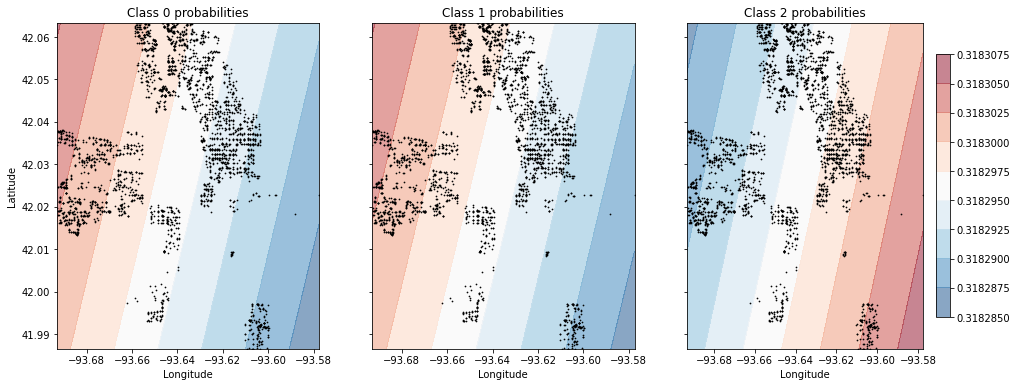

In [12]:
plot_class_probs(logreg)

**Compute the accuracy and cross-entropy loss.** You can use `accuracy_score` and `log_loss`. You'll need to use `predict_proba` for one of these (which one?) to ask the classifier to tell you its probabilities, not just its best guess.

Note: *cross-entropy loss* is also known as *log loss*; think about why.

In [16]:
def summarize_classifier(clf, X_valid, y_valid):
    y_pred = clf.predict(X_valid)
    y_predict_proba = clf.predict_proba(X_valid)
    print("Accuracy: {:.3f}".format(accuracy_score(y_valid, y_pred)))
    print("Log loss: {:.3f}".format(log_loss(y_valid, y_predict_proba)))
summarize_classifier(logreg, X_valid, y_valid)

Accuracy: 0.294
Log loss: 1.103


### Part B: Decision tree classifier

**Fit a decision tree classifier (call it `dtree_clf`) to the training set**. Use the default hyperparameters.

In [17]:
dtree_clf = DecisionTreeClassifier().fit(X_train, y_train)

Let's plot the probabilities for this classifier.

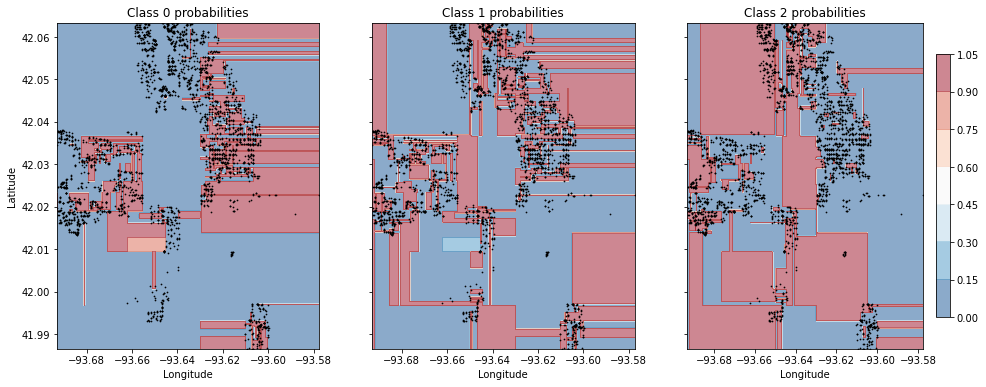

In [18]:
plot_class_probs(dtree_clf)

**Compute the accuracy and cross-entropy loss**. Be careful to use the correct classifier each time!

In [19]:
summarize_classifier(dtree_clf, X_valid, y_valid)

Accuracy: 0.710
Log loss: 10.020


### Part C: Random Forest

A random forest consists of many different decision trees, but:

1. Each tree only gets a random subset of the training data
2. Each time the tree splits, it only gets to look at a random subset of the features. (We're only using two features overall, so this doesn't make much difference.)

To make a decision, it averages the decisions of each tree. (This means it's an "ensemble" method.)

The net effect is that an RF can fit the data well (since each tree is a pretty good predictor) but it tends not to *overfit* because it averages the predictions of trees trained on different subsets of data.

Let's try it.

**Fit a random forest classifier to the training set.**

In [22]:
rf_clf = RandomForestClassifier().fit(X_train, y_train)

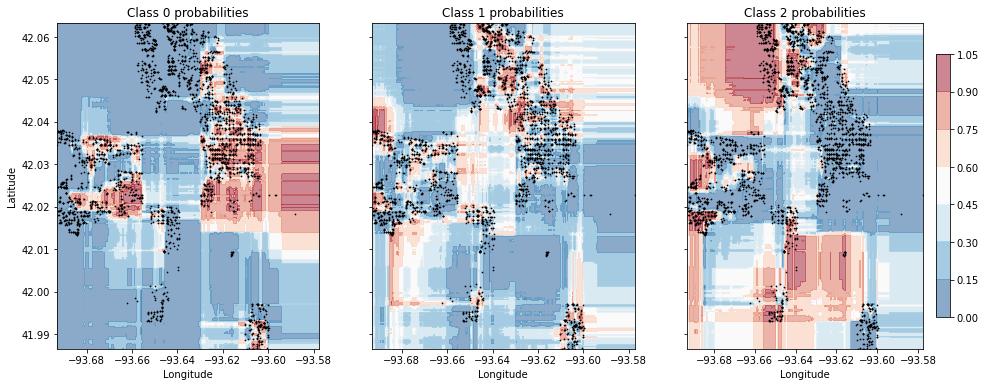

In [23]:
plot_class_probs(rf_clf)

**Compute the accuracy and cross-entropy loss**. Be careful to use the correct classifier each time!

In [ ]:
# your code here

Accuracy: 0.753
Log loss: 0.894


## Analysis

**How does the accuracy compare between the three classifiers?**

Quantitatively, the RF classifier had the highest accuracy, then the decision tree classfier. Finally, the logistic regression classifier had the lowest accuracy. 

**How does the cross-entropy loss compare between the three classifiers?** Why is the ranking different for this loss compared with accuracy? Look at the actual values. Hint:

In [ ]:
np.log(3)

1.0986122886681098

Loss-wise, decision tree had the highest, then the logistic regression, then the RF (which has the lowest loss). 

**Describe, qualitatively, the class probability plots.** Do the quantitative numbers make sense in light of these plots?

Similar to linear regression, the logistic regression plot categorized the probabilities more evenly (in terms of the color sections). The decision tree seemed more binary (blue or red in this case, not as gradient-coloured as the logistic regression). Finally, the random forest tree has more colours, but it's more similar to the decision tree than the logistic regression. The quantitative numbers in the logistic regression seem interesting because the differences are very small between the numbers (thousandths place). 

**Which of these classifiers *overfit*? Which ones *underfit*?**

The overfitted plot seems to be the logistic regression as its super minute in terms of sectioning the colours by the thousandths place. The underfitting seems to be the decision tree (as it only separates by the extremes of 1.05 or 0.00). However, I might have this logic reversed.

## Extension

*optional*

1. Compute the loss on the *training* set for each of these classifiers. Can that help you tell whether your classifier overfit or not?
2. Try using more features in the dataset. How well can you classify? Be careful about *categorical* features.